In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy.cluster import cmeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
from skfuzzy.control.visualization import ControlSystemVisualizer


In [2]:
df = pd.read_excel(r'C:\Users\USER\Desktop\HTU\First Semester 4rth Year\Applied Analytical Modelling\gold_futures.xlsx')
df

,Date,Open,High,Low,Close,Adj Close,Volume,Price Movement
0,2020-01-02,1518.099976,1528.699951,1518.000000,1524.500000,1524.500000,214,Up
1,2020-01-03,1530.099976,1552.699951,1530.099976,1549.199951,1549.199951,107,Up
2,2020-01-06,1580.000000,1580.000000,1560.400024,1566.199951,1566.199951,416,Up
3,2020-01-07,1558.300049,1576.300049,1558.300049,1571.800049,1571.800049,47,Up
4,2020-01-08,1579.699951,1604.199951,1552.300049,1557.400024,1557.400024,236,Down
...,...,...,...,...,...,...,...,...
1240,2024-12-10,2662.300049,2698.199951,2661.000000,2697.600098,2697.600098,437,Up
1241,2024-12-11,2701.800049,2733.800049,2693.100098,2733.800049,2733.800049,3387,Up
1242,2024-12-12,2725.100098,2725.100098,2677.399902,2687.500000,2687.500000,2365,Down
1243,2024-12-13,2688.199951,2689.300049,2647.899902,2656.000000,2656.000000,1125,Down


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1245 non-null   datetime64[ns]
 1   Open            1245 non-null   float64       
 2   High            1245 non-null   float64       
 3   Low             1245 non-null   float64       
 4   Close           1245 non-null   float64       
 5   Adj Close       1245 non-null   float64       
 6   Volume          1245 non-null   int64         
 7   Price Movement  1245 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 77.9+ KB


## 1. implement membership functions

In [4]:
# Define the range for the 'High' column
high_min = df['High'].min()
high_max = df['High'].max()

In [5]:
# Create Triangular Membership Functions
tri_low = fuzz.trimf(df['High'], [high_min, high_min, (high_min + high_max) / 2])
tri_medium = fuzz.trimf(df['High'], [high_min, (high_min + high_max) / 2, high_max])
tri_high = fuzz.trimf(df['High'], [(high_min + high_max) / 2, high_max, high_max])

In [6]:
# Create Gaussian Membership Functions
gauss_low = fuzz.gaussmf(df['High'], high_min, (high_max - high_min) / 4)
gauss_medium = fuzz.gaussmf(df['High'], (high_min + high_max) / 2, (high_max - high_min) / 4)
gauss_high = fuzz.gaussmf(df['High'], high_max, (high_max - high_min) / 4)

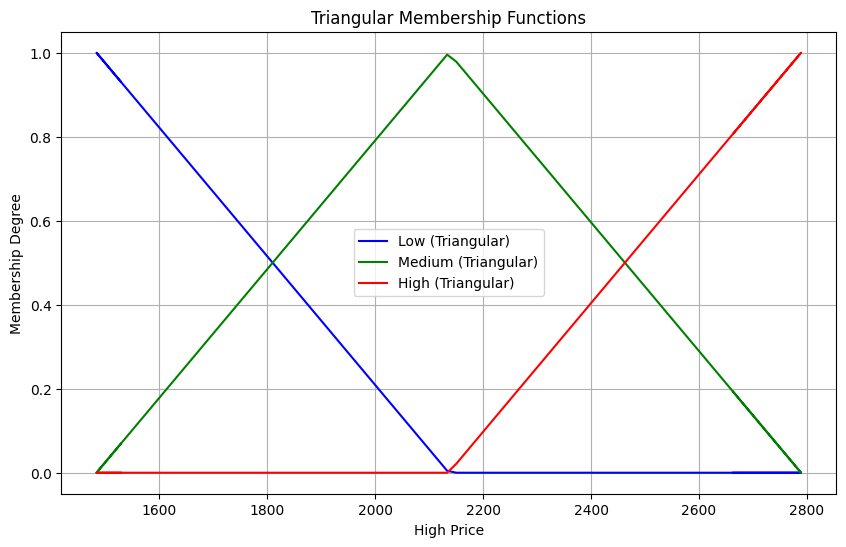

In [7]:
# Plot Triangular Membership Functions
plt.figure(figsize=(10, 6))
plt.plot(df['High'], tri_low, label='Low (Triangular)', color='blue')
plt.plot(df['High'], tri_medium, label='Medium (Triangular)', color='green')
plt.plot(df['High'], tri_high, label='High (Triangular)', color='red')
plt.title('Triangular Membership Functions')
plt.xlabel('High Price')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid()
plt.show()

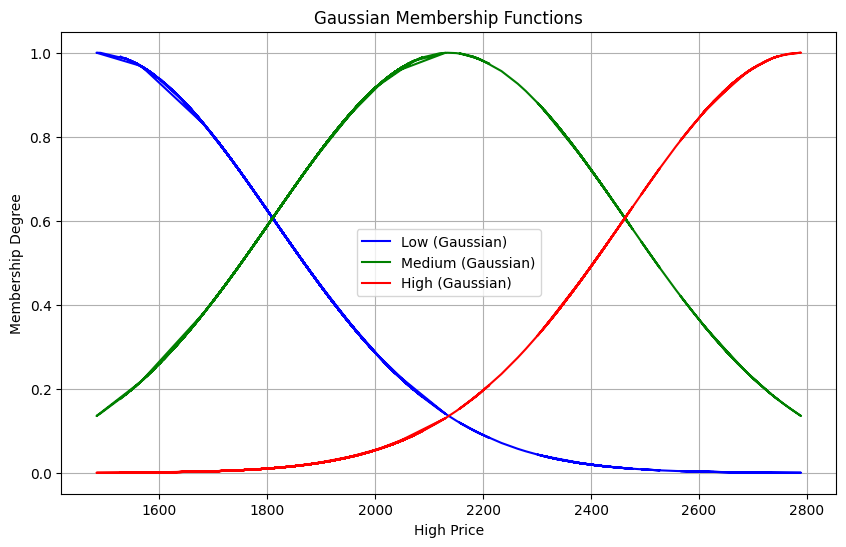

In [8]:
# Plot Gaussian Membership Functions
plt.figure(figsize=(10, 6))
plt.plot(df['High'], gauss_low, label='Low (Gaussian)', color='blue')
plt.plot(df['High'], gauss_medium, label='Medium (Gaussian)', color='green')
plt.plot(df['High'], gauss_high, label='High (Gaussian)', color='red')
plt.title('Gaussian Membership Functions')
plt.xlabel('High Price')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid()
plt.show()

## 2. Apply C-Fuzzy Means (FCM) Clustering

In [9]:
# Select features for clustering
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values.T

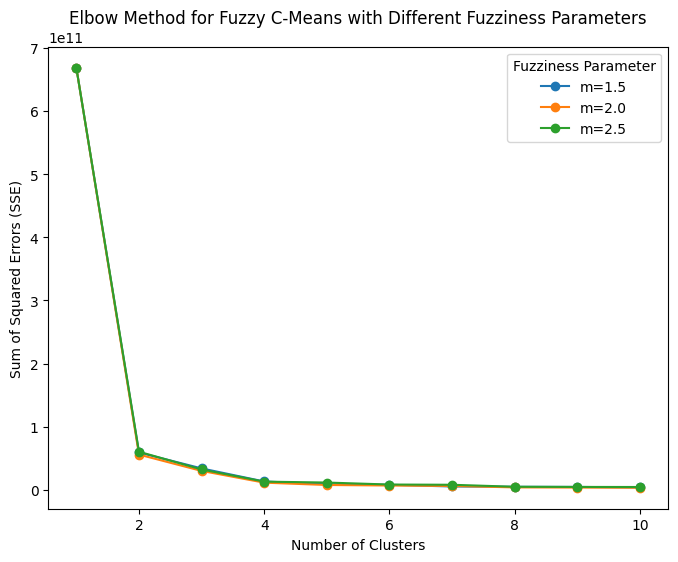

In [10]:
# Define the range of clusters and fuzziness parameters
cluster_range = range(1, 11)
m_values = [1.5, 2.0, 2.5]  # Different fuzziness parameters
results = []

# Loop over different numbers of clusters and fuzziness parameters
for m in m_values:
    sse_values = []  # To store SSE for each cluster number
    
    for n in cluster_range:
        # Apply fuzzy c-means clustering
        cntr, u, _, _, _, _, _ = fuzz.cmeans(features, c=n, m=m, error=0.005, maxiter=1000, init=None)
        
        # Calculate the sum of squared errors (SSE)
        sse = 0
        for i in range(features.shape[1]):
            for j in range(n):  # Loop over clusters
                dist = np.linalg.norm(features[:, i] - cntr[j])
                sse += (u[j, i] ** 2) * dist ** 2
        
        sse_values.append(sse)
    
    # Store results for each fuzziness parameter
    results.append((m, sse_values))

# Plot the elbow curves for different fuzziness parameters
plt.figure(figsize=(8, 6))
for m, sse_values in results:
    plt.plot(cluster_range, sse_values, marker='o', label=f"m={m}")

plt.title('Elbow Method for Fuzzy C-Means with Different Fuzziness Parameters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.legend(title='Fuzziness Parameter')
plt.show()

In [11]:
# Define parameters
n_clusters = 4  # Number of clusters
m_values = [1.5, 2.0, 2.5]  # Different fuzziness parameters
results = []

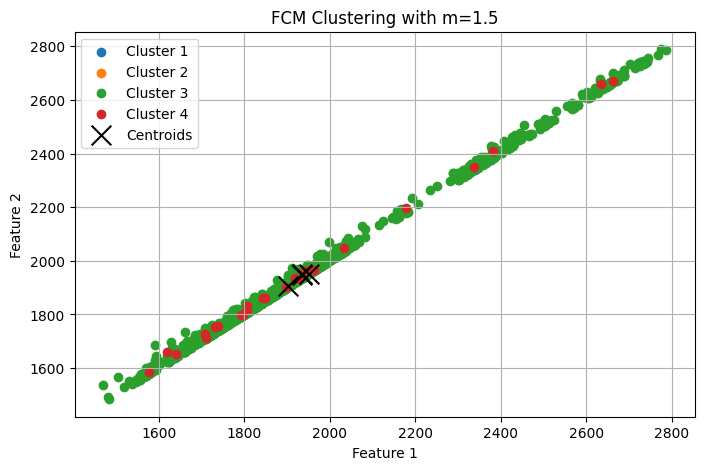

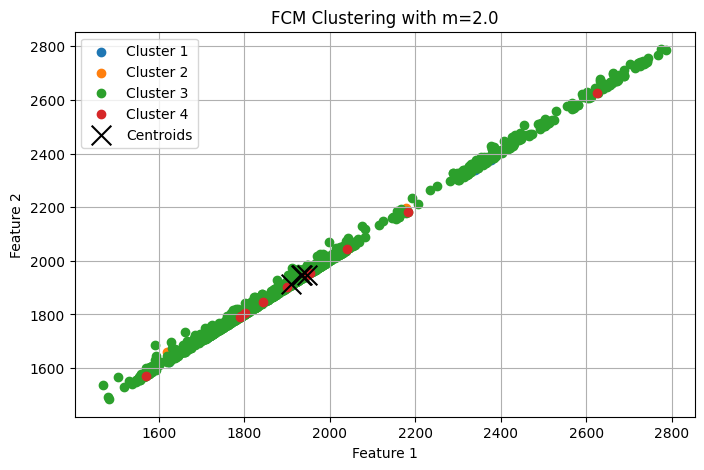

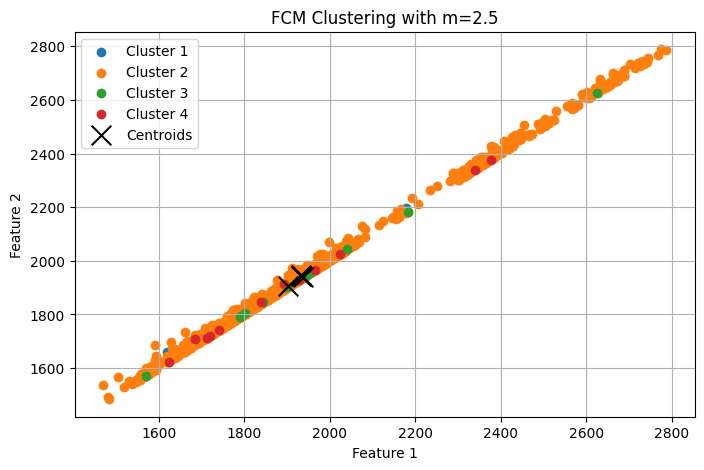

   Fuzziness Parameter (m)       FPC  Silhouette Score
0                      1.5  0.995408          0.949786
1                      2.0  0.989075          0.949242
2                      2.5  0.970469          0.949242


In [12]:
# FCM Clustering
for m in m_values:
    # Perform clustering
    cntr, u, u0, d, jm, p, fpc = cmeans(
        features, c=n_clusters, m=m, error=0.005, maxiter=1000, init=None
    )
    
    # Assign clusters
    cluster_labels = np.argmax(u, axis=0)
    
    # Calculate silhouette score
    try:
        silhouette_avg = silhouette_score(features.T, cluster_labels)
    except ValueError:
        silhouette_avg = None  # Silhouette score not defined for 1 cluster
    
    # Store results
    results.append((m, fpc, silhouette_avg))
    
    # Plot cluster memberships
    plt.figure(figsize=(8, 5))
    for i in range(n_clusters):
        plt.scatter(
            features[0, cluster_labels == i],
            features[1, cluster_labels == i],
            label=f"Cluster {i + 1}"
        )
    plt.scatter(cntr[:, 0], cntr[:, 1], marker="x", s=200, color="black", label="Centroids")
    plt.title(f"FCM Clustering with m={m}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid()
    plt.show()

# Summarize results
summary_df = pd.DataFrame(results, columns=["Fuzziness Parameter (m)", "FPC", "Silhouette Score"])
print(summary_df)

## 3. Construct a Fuzzy Inference System (FIS)

In [13]:
print(df['Price Movement'].unique())

['Up' 'Down']


In [14]:
# Define fuzzy variables for Volume and Price Movement
volume = ctrl.Antecedent(np.arange(df['Volume'].min(), df['Volume'].max()), 'Volume')
price_movement = ctrl.Antecedent(np.array([-1, 1]), 'Price Movement')
market_condition = ctrl.Consequent(np.arange(0, 11, 1), 'Market Condition', defuzzify_method='MOM')

# Define membership functions for Volume
volume['Low'] = fuzz.trimf(volume.universe, [df['Volume'].min(), df['Volume'].min(), df['Volume'].max() / 2])
volume['Medium'] = fuzz.trimf(volume.universe, [df['Volume'].min(), df['Volume'].max() / 2, df['Volume'].max()])
volume['High'] = fuzz.trimf(volume.universe, [df['Volume'].max() / 2, df['Volume'].max(), df['Volume'].max()])

# Define membership functions for Price Movement
price_movement['Down'] = fuzz.trimf(price_movement.universe, [-1, -1, 1])
price_movement['Up'] = fuzz.trimf(price_movement.universe, [-1, 1, 1])

In [15]:
# Define membership functions for Market Condition
market_condition['Bearish'] = fuzz.trimf(market_condition.universe, [0, 0, 5])
market_condition['Neutral'] = fuzz.trimf(market_condition.universe, [0, 5, 10])
market_condition['Bullish'] = fuzz.trimf(market_condition.universe, [5, 10, 10])


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


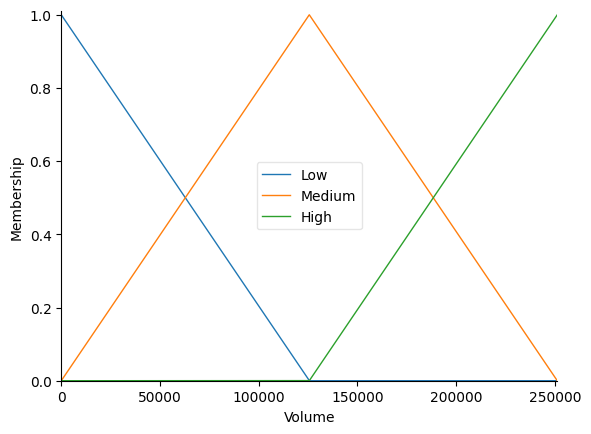

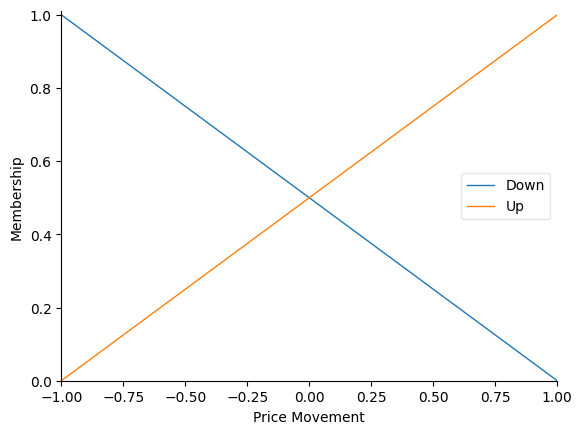

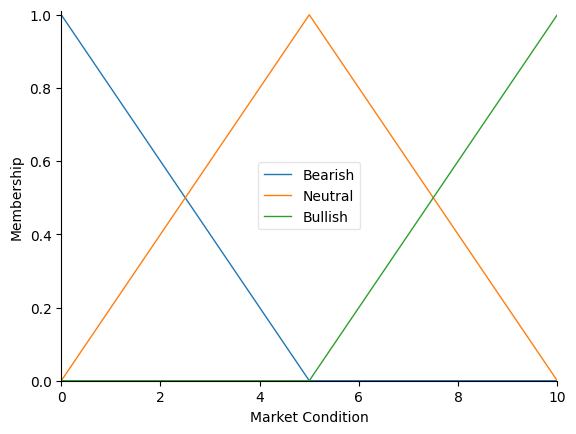

In [16]:
# Visualize membership functions
volume.view()
price_movement.view()
market_condition.view()
plt.show()

In [17]:
# Define fuzzy rules
rule1 = ctrl.Rule(volume['Low'] & price_movement['Down'], market_condition['Bearish'])
rule2 = ctrl.Rule(volume['Low'] & price_movement['Up'], market_condition['Neutral'])
rule3 = ctrl.Rule(volume['Medium'] & price_movement['Down'], market_condition['Bearish'])
rule4 = ctrl.Rule(volume['Medium'] & price_movement['Up'], market_condition['Neutral'])
rule5 = ctrl.Rule(volume['High'] & price_movement['Down'], market_condition['Neutral'])
rule6 = ctrl.Rule(volume['High'] & price_movement['Up'], market_condition['Bullish'])

# Create control system and simulation
market_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
market_sim = ctrl.ControlSystemSimulation(market_ctrl)

min volume:  0
max volume:  251274
Sample Volume:  214
Sample Price Movement:  Up
Defuzzified Market Condition: 5.0
Neutral


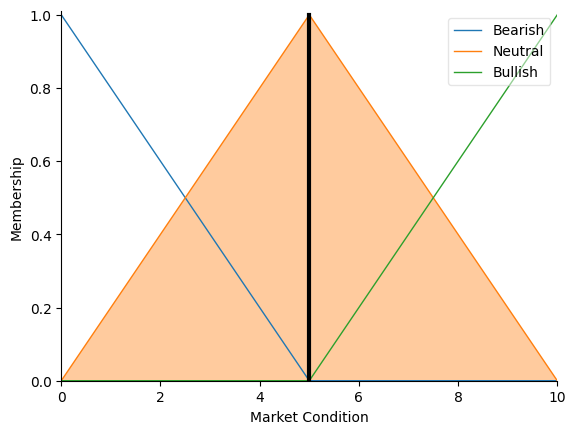

In [18]:
# Test the system with sample inputs

#print min and max volume
print('min volume: ', df['Volume'].min())
print('max volume: ', df['Volume'].max())

# choose the first sample in the df for price movement and volume
sample_volume = df['Volume'][0]
sample_price_movement = df['Price Movement'][0]

# print the sample volume and price movement
print('Sample Volume: ', sample_volume)
print('Sample Price Movement: ', sample_price_movement)

market_sim.input['Volume'] = sample_volume
market_sim.input['Price Movement'] = sample_price_movement

# Compute the result
market_sim.compute()

# Display output
print(f"Defuzzified Market Condition: {market_sim.output['Market Condition']}")

#print bearish, neutral, bullish depending on the output
if market_sim.output['Market Condition'] < 5:
    print('Bearish')
elif market_sim.output['Market Condition'] > 5:
    print('Bullish')
else:
    print('Neutral')


# Visualize the result
market_condition.view(sim=market_sim)
plt.show()

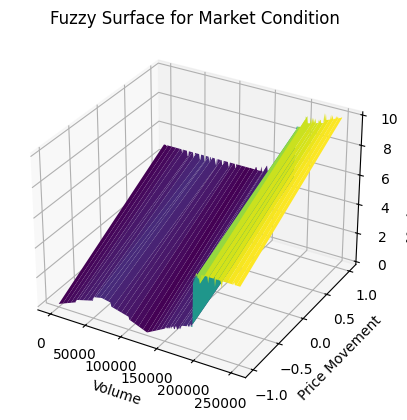

In [19]:
volume_range = np.arange(df['Volume'].min(), df['Volume'].max() + 1, 1000)
price_movement_range = np.array([-1, 1])
volume_grid, price_movement_grid = np.meshgrid(volume_range, price_movement_range)

# Flatten the grids for computation
volume_flat = volume_grid.flatten()
price_movement_flat = price_movement_grid.flatten()

# Create a list to store the output for each combination of input values
output_values = []

# Loop through all possible combinations of volume and price movement
for vol, pm in zip(volume_flat, price_movement_flat):
    market_sim.input['Volume'] = vol
    market_sim.input['Price Movement'] = pm
    market_sim.compute()
    output_values.append(market_sim.output['Market Condition'])

# Reshape the output to match the shape of the input grid
output_values = np.array(output_values).reshape(volume_grid.shape)

# Plot the fuzzy surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(volume_grid, price_movement_grid, output_values, cmap='viridis')

# Label the axes
ax.set_xlabel('Volume')
ax.set_ylabel('Price Movement')
ax.set_zlabel('Market Condition')
ax.set_title('Fuzzy Surface for Market Condition')

plt.show()

## 4. Design an Advanced Fuzzy Logic System

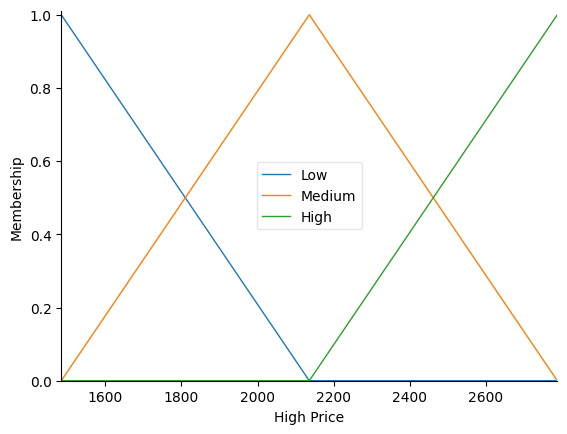

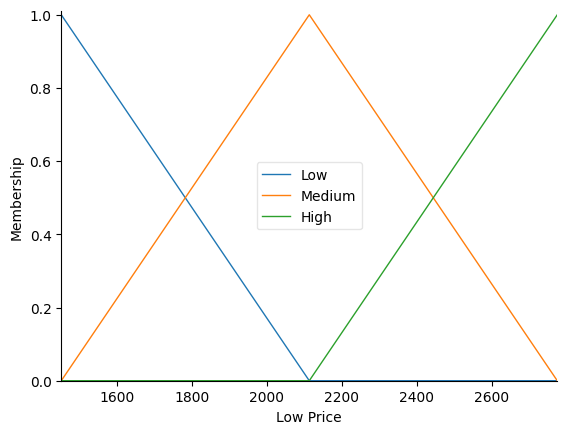

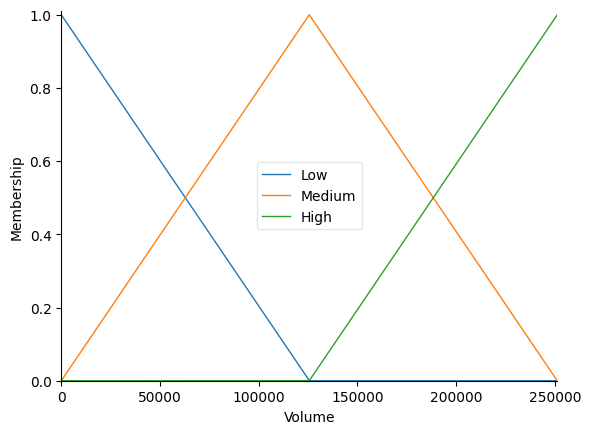

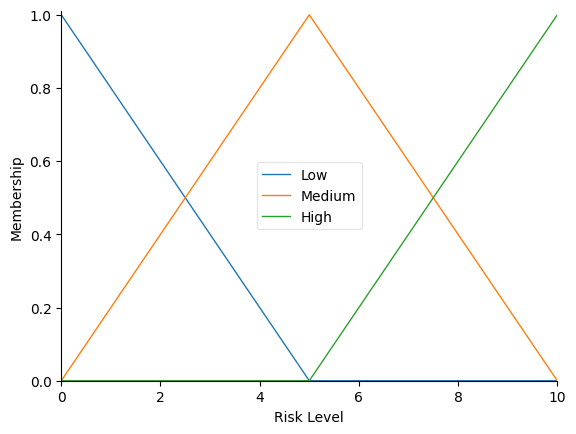

In [20]:
# Define fuzzy variables for High Price, Low Price, Volume, and Risk Level
high_price = ctrl.Antecedent(np.arange(df['High'].min(), df['High'].max(), 1), 'High Price')
low_price = ctrl.Antecedent(np.arange(df['Low'].min(), df['Low'].max(), 1), 'Low Price')
volume = ctrl.Antecedent(np.arange(df['Volume'].min(), df['Volume'].max(), 1), 'Volume')
risk_level = ctrl.Consequent(np.arange(0, 11, 1), 'Risk Level', defuzzify_method='centroid')

# Define membership functions
high_price.automf(3, names=['Low', 'Medium', 'High'])
low_price.automf(3, names=['Low', 'Medium', 'High'])
volume.automf(3, names=['Low', 'Medium', 'High'])
risk_level.automf(3, names=['Low', 'Medium', 'High'])

# Visualize membership functions
high_price.view()
low_price.view()
volume.view()
risk_level.view()
plt.show()

In [21]:
# Define fuzzy rules using for loops
rules = []
for hp in high_price.terms:
    for lp in low_price.terms:
        for v in volume.terms:
            if hp == 'High' and v == 'High':
                risk = 'High'
            elif hp == 'High' and v == 'Low':
                risk = 'High'
            elif lp == 'High' and v == 'High':
                risk = 'Medium'
            elif lp == 'High' and v == 'Low':
                risk = 'Low'
            else:
                risk = 'Medium'  # default case
            rule = ctrl.Rule(high_price[hp] & low_price[lp] & volume[v], risk_level[risk])
            rules.append(rule)

# Create control system and simulation
risk_ctrl = ctrl.ControlSystem(rules)
risk_simulation = ctrl.ControlSystemSimulation(risk_ctrl)


In [22]:
#print max and min of high price, low price and volume
print('min high price: ', df['High'].min())
print('max high price: ', df['High'].max())
print('min low price: ', df['Low'].min())
print('max low price: ', df['Low'].max())
print('min volume: ', df['Volume'].min())
print('max volume: ', df['Volume'].max())

min high price:  1484.0
max high price:  2789.0
min low price:  1452.099976
max low price:  2774.600098
min volume:  0
max volume:  251274


In [23]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Price Movement
0,2020-01-02,1518.099976,1528.699951,1518.000000,1524.500000,1524.500000,214,Up
1,2020-01-03,1530.099976,1552.699951,1530.099976,1549.199951,1549.199951,107,Up
2,2020-01-06,1580.000000,1580.000000,1560.400024,1566.199951,1566.199951,416,Up
3,2020-01-07,1558.300049,1576.300049,1558.300049,1571.800049,1571.800049,47,Up
4,2020-01-08,1579.699951,1604.199951,1552.300049,1557.400024,1557.400024,236,Down


Sample Inputs:
High Price: 500
Low Price: 400
Volume: 1
Defuzzified Risk Level: 5.000000000000001


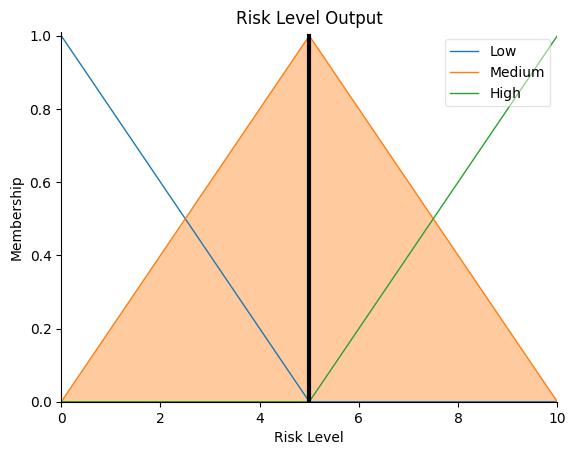

In [26]:
# Select sample inputs from the dataset
sample = df.iloc[0]  # Using the first row as an example
sample_high_price = 500
sample_low_price = 400
sample_volume = 1

# Set inputs
risk_simulation.input['High Price'] = sample_high_price
risk_simulation.input['Low Price'] = sample_low_price
risk_simulation.input['Volume'] = sample_volume

# Compute the result
risk_simulation.compute()

# Display defuzzified output
print(f"Sample Inputs:")
print(f"High Price: {sample_high_price}")
print(f"Low Price: {sample_low_price}")
print(f"Volume: {sample_volume}")
print(f"Defuzzified Risk Level: {risk_simulation.output['Risk Level']}")

# Visualize the output membership
risk_level.view(sim=risk_simulation)
plt.title('Risk Level Output')
plt.show()

# Since visualizing a surface with three inputs is complex, we'll fix one input and plot the surface over the other two.

# # Fix Low Price at a specific value
# fixed_low_price = 1500

# # Create a grid for High Price and Volume
# high_price_range = np.linspace(high_price.universe.min(), high_price.universe.max(), 50)
# volume_range = np.linspace(volume.universe.min(), volume.universe.max(), 50)
# high_price_grid, volume_grid = np.meshgrid(high_price_range, volume_range)

# # Initialize Risk Level grid
# risk_level_grid = np.zeros(high_price_grid.shape)

# # Iterate over the grid and compute Risk Level
# for i in range(high_price_grid.shape[0]):
#     for j in range(high_price_grid.shape[1]):
#         risk_simulation.input['High Price'] = high_price_grid[i, j]
#         risk_simulation.input['Low Price'] = fixed_low_price
#         risk_simulation.input['Volume'] = volume_grid[i, j]
#         try:
#             risk_simulation.compute()
#             risk_level_grid[i, j] = risk_simulation.output['Risk Level']
#         except:
#             risk_level_grid[i, j] = np.nan  # Handle any computation errors

# # Plot the surface
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(high_price_grid, volume_grid, risk_level_grid, cmap='viridis', edgecolor='none')
# ax.set_title('Risk Level Surface Plot (Low Price Fixed at 1500)')
# ax.set_xlabel('High Price')
# ax.set_ylabel('Volume')
# ax.set_zlabel('Risk Level')
# plt.show()